#  Identifying Cellular Neighborhoods with Graph Neural Networks in Spatial Transcriptomics Data

### Project Introduction
...

--- 
### References

**Data Sources and Platforms**
* [10X Genomics](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0): Invasive Ductal Carcinoma tissue.

**Libraries**
* [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

* [SquidPy Docs](https://squidpy.readthedocs.io/en/stable/)

* [ScanPy Docs](https://scanpy.readthedocs.io/en/stable/)

---
### Table of Contents

1. [Imports](#imports)
2. [Constants & Data](#constants)
3. [...](#distributions)

6. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


---
### 2. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the [10X Genomics Datasets Site](https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0). The following specific datasets are required:

* **Filtered feature barcode matrix**

    *V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix* 
    
    This is your core gene expression data that contains a matrix where the rows are genes and the columns are the unique barcodes for each spot on the tissue slide.

* **Spatial imaging data**

    *V1_Breast_Cancer_Block_A_Section_1_spatial.tar.gz*

    Compressed folder contains all the crucial spatial information including files like tissue_positions.csv, which has the exact (x, y) pixel coordinates for every spot/barcode. 

* **Tissue Image**

    *V1_Breast_Cancer_Block_A_Section_1_image.tif*

    High-resolution H&E stained image of the tissue slice


The notebook expects both tsv files to be placed in the `data/10x` folder.

In [2]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "10x")
SPATIAL_DATA_PATH = os.path.join(DATA_PATH, "spatial")
H5_DATA_PATH = os.path.join(
    DATA_PATH, "V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"
)

---
### 3. Pre-processing & Data Exploration <a class="anchor" id="constants"></a>

Load the data into an AnnData object

In [3]:
adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)
adata.var_names_make_unique()  # Ensure gene names are unique
adata

/var/folders/wt/5vc39b651nn6m5wm29j25dk80000gn/T/ipykernel_37280/2461471614.py:1: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(path=DATA_PATH, count_file=H5_DATA_PATH)


/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

#### Pre-process the data

In [4]:
sc.pp.filter_genes(
    adata, min_cells=10
)  # Filter out genes expressed in fewer than 10 spots
sc.pp.normalize_total(adata, inplace=True)  # Normalize counts per spot
sc.pp.log1p(adata)  # Log-transform the data
# Calculate quality control metrics, adding total_counts (total number of gene counts per spot)
sc.pp.calculate_qc_metrics(adata, inplace=True)  

adata

AnnData object with n_obs × n_vars = 3798 × 19690
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

#### Explore the data object

**adata.uns, adata.obsm**

Display the image of the slide from`adata.uns` and plot the scatter plot from the spatial spot coordinates from `adata.obsm` (colored by the total counts in `adata.obs` to indicate expression per spot).

dict_keys(['images', 'scalefactors', 'metadata'])
{'chemistry_description': "Spatial 3' v1", 'software_version': 'spaceranger-1.1.0'}
None


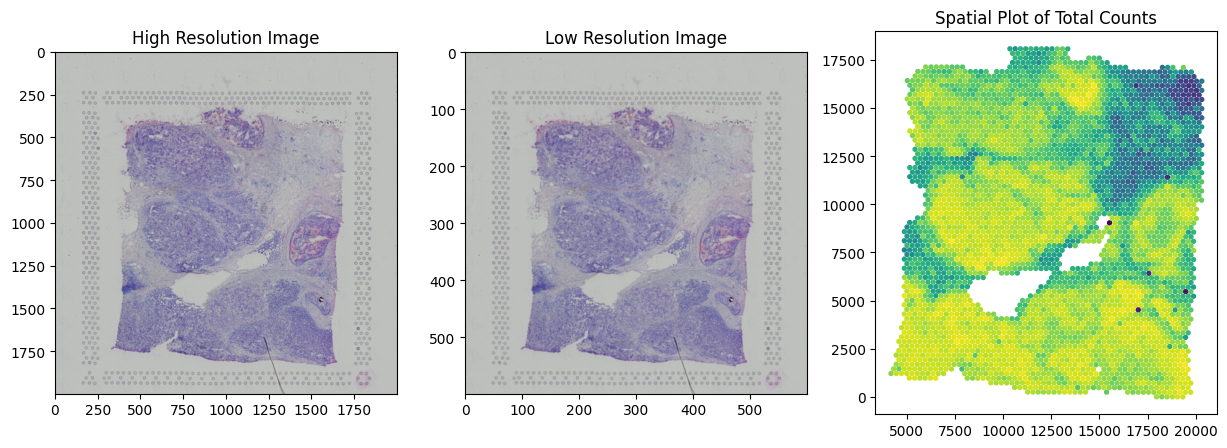

In [5]:
print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"].keys())
print(print(adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["metadata"]))
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["hires"]
)
axes[0].set_title("High Resolution Image")

axes[1].set_title("Low Resolution Image")
axes[1].imshow(
    adata.uns["spatial"]["V1_Breast_Cancer_Block_A_Section_1"]["images"]["lowres"]
)

axes[2].scatter(
    x = adata.obsm["spatial"][:,0],
    y = adata.obsm["spatial"][:,1]*-1 - min(adata.obsm["spatial"][:,1]*-1), # invert y-axis
    c = adata.obs["total_counts"],
    cmap="viridis",
    s=8,
    )
axes[2].set_title("Spatial Plot of Total Counts")
axes[0].set_aspect('equal')  
axes[1].set_aspect('equal')  
axes[2].set_aspect('equal')  


**adata.var**

Each row in adata.var corresponds to a single gene. The important columns in adata.var for this notebook include:

* `gene_ids`: The Ensembl ID for the gene.
* `feature_types`: The type of featureb entirely "Gene Expression" for this data.
* `genome`: The reference genome used.
* `n_cells`: A column added by scanpy after filtering, showing in how many spots (cells) each gene was detected.
* `total_counts`: A quality control metric showing the total number of counts for each gene across all spots.
* `mean_counts`: average expression across the data set
* `log1p_mean_counts`: log-transformed version of `mean_counts`

In [6]:
print(adata.var.shape)
adata.var.head(2)

(19690, 10)


,gene_ids,feature_types,genome,n_cells,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,118,118,0.018013,0.017853,96.893102,68.412788,4.240071
AP006222.2,ENSG00000286448,Gene Expression,GRCh38,15,15,0.002494,0.002491,99.605055,9.472625,2.348765


**adata.var**

Each row in adata.obs corresponds to a observation, or spot on the tissue slide. The important columns in adata.obs for this notebook include:

* `in_tissue`: A binary column (0 or 1) indicating whether the spot is located over the actual tissue section (1) or in the background (0).
* `array_row` and `array_col`: These are the integer row and column coordinates of the spot on the physical grid of the Visium slide.
* `total_counts`: This is the total number of gene transcripts (UMIs) detected in that specific spot. It's a measure of the sequencing depth or "library size" for that spot. 
* `n_genes_by_counts`: The number of unique genes that were detected in that spot. A very low number might indicate a low-quality spot.
* `log1p_total_counts`: The log-transformed version of total_counts.

In [7]:
print(adata.obs.shape)
adata.obs.head(2)

(3798, 11)


,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
AAACAAGTATCTCCCA-1,1,50,102,4403,8.390268,6018.627441,8.702781,3.652838,6.624900,11.541192,22.751365
AAACACCAATAACTGC-1,1,59,19,8984,9.103312,7362.225098,8.904253,2.917385,5.366046,9.465522,18.650963


Construct a graph using squidpy's 'spatial_neighbors' function which builds a graph by connecting each spot to its nearest neighbors.  The hue on the scatter plot corresponds to the total number of gene transcripts detected in each spot.

spatial_connectivities: (3798, 3798)
spatial_distances: (3798, 3798)


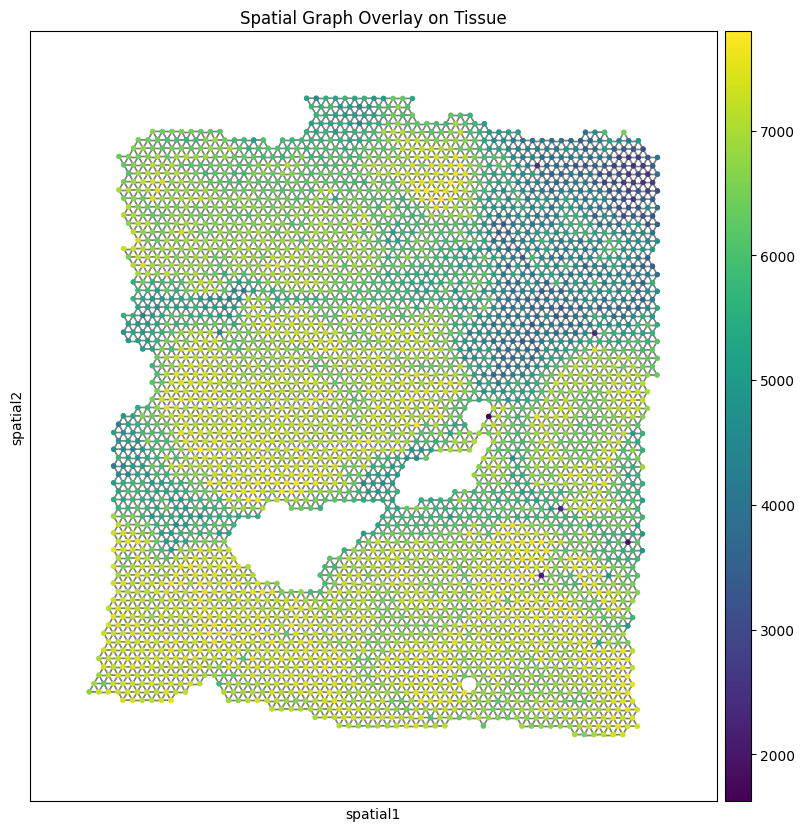

In [8]:
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
for k, v in adata.obsp.items():
    print(f"{k}: {v.shape}")

_, axes = plt.subplots(figsize=(10, 10))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",  # Use the key for the image
    color="total_counts",  # Color spots by total gene counts as an example
    shape=None,
    connectivity_key="spatial_connectivities",  # Tell squidpy to draw the graph
    title="Spatial Graph Overlay on Tissue",
    ax=axes,
)

**Observations**: 
* This slide contains 3,798 spots and 19,690 genes sampled.
* Total counts seem to correlate with cell density. The areas with the highest total_counts (the bright yellow spots) visually align with the densest, most purple regions in the H&E image. Conversely, the blue/darker areas with lower counts correspond to less dense regions (like stroma or connective tissue).
* The clear spatial pattern of high-count and low-count regions demonstrates that the tissue is heterogeneous. This heterogeneity should be leveraged by our GNN to learn if and where there are different types of genes being expressed.

---
### 4. Build the Model <a class="anchor" id="model"></a>

...

Critical data for the GNN will be 
* `adata.X`: a sparse matrix that is n (number of spots) x m (number of genes) in size that contains gene expression at each spot.
* `adata.obs['spatial_connectivities']`: the graph adjacency matrix

Visualize the gene expression matrix

In [26]:
top_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][:10]
bottom_ten_highest_gene_idx = np.argsort(adata.X.toarray().mean(axis=0))[::-1][-10:]

In [30]:
adata.X.toarray().shape

(3798, 19690)

In [32]:

adata.X.toarray()[np.random.randint(10), top_ten_highest_gene_idx]

array([6.0645065, 4.818445 , 4.1643953, 4.503413 , 5.125381 , 4.0815673,
       4.1270175, 4.5626163, 4.268813 , 4.1077914], dtype=float32)

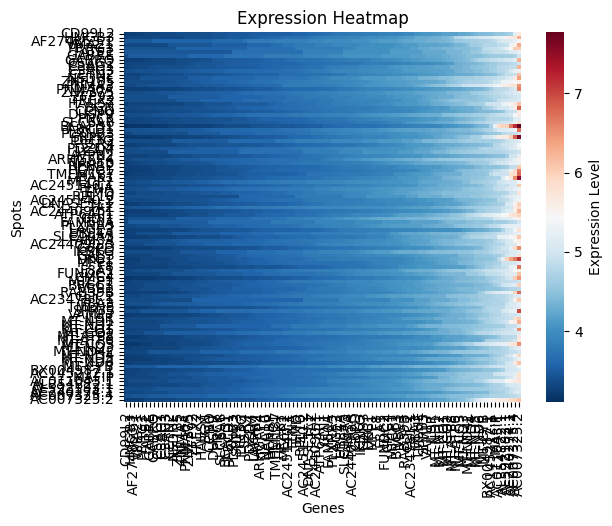

In [22]:
sns.heatmap(
    np.sort(adata.X.toarray())[
        -100:, -100:
    ],
    cmap="RdBu_r",
    cbar_kws={"label": "Expression Level"},
    xticklabels=adata.var_names[-100:],
    yticklabels=adata.var_names[-100:],
    )
plt.title("Expression Heatmap")
plt.xlabel("Genes")
plt.ylabel("Spots");

Some genes have relatively high expression over all spots in the slide indicated by the vertical lines in the heatmap above.

Convert the spatial connectivites from it's native matrix to COOrdinate sparse matrix.

In [ ]:
adata.obsp['spatial_connectivities']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [ ]:
adata.obsp['spatial_connectivities'].tocoo()

<COOrdinate sparse matrix of dtype 'float64'
	with 22064 stored elements and shape (3798, 3798)>

In [ ]:
print(f"Shape of spatial coordinates: {adata.obsm['spatial'].shape}")
print("First 5 coordinate pairs:")
print(adata.obsm['spatial'][:5])

<Axes: >

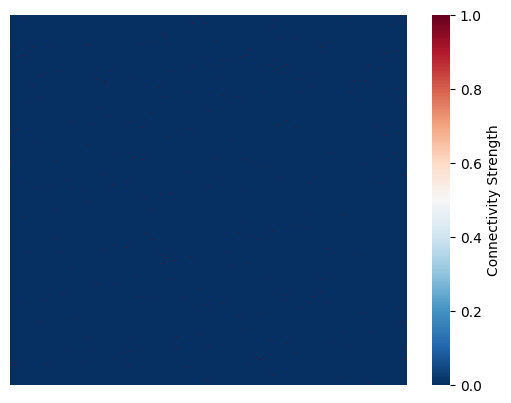

In [ ]:
sns.heatmap(
    adata.obsp['spatial_connectivities'].toarray(),
    cmap="RdBu_r",
    cbar_kws={"label": "Connectivity Strength"},
    xticklabels=[],
    yticklabels=[],
    annot=False,
    )

PyTorch Geometric models require a specific 'Data' object that holds the graph structure. Convert the Snapy AnnData to a compatible structure - COO (adjacency matrix) format for edges and dense torch tensor for the nodes (gene expression matrix).

In [ ]:
# Edges - we will use the spatial connectivities computed by Squidpy
edge_index_coo = adata.obsp['spatial_connectivities'].tocoo()
edge_index = torch.tensor(np.vstack([edge_index_coo.row, edge_index_coo.col]), dtype=torch.long)

# Nodes - we will use the gene expression matrix as node features
x = torch.tensor(adata.X.toarray(), dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=edge_index)
print("--- PyTorch Geometric Data Object ---")
print(data)

--- PyTorch Geometric Data Object ---
Data(x=[3798, 19690], edge_index=[2, 22064])


---
### 6. Summary

...

The primary findings include:
* ...